In [19]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

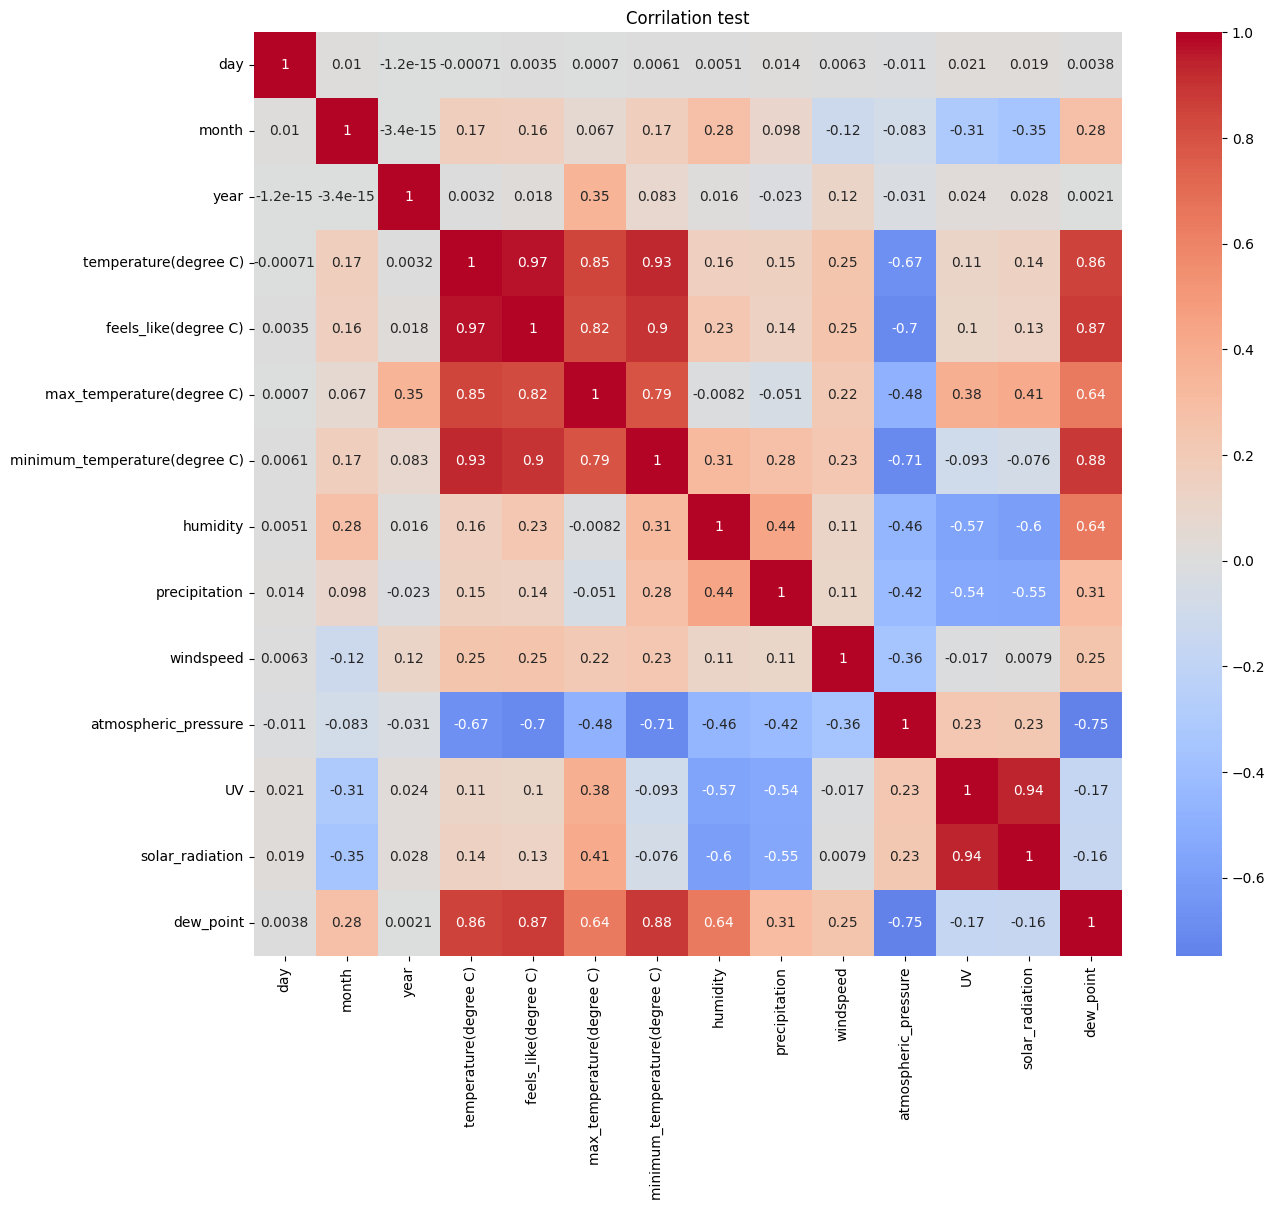

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix
corr_matrix = df_bandarban.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Corrilation test')
plt.show()

# temperature

In [21]:
df_bandarban.head()

,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


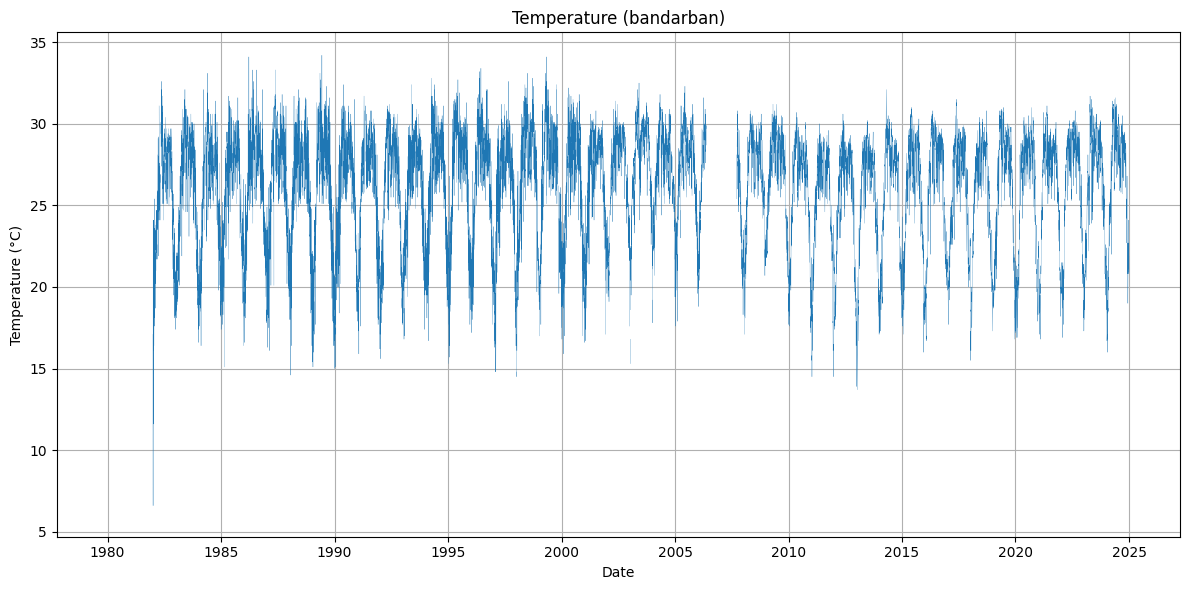

In [22]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2014-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature (bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# RF with lagging rollibng

- time series part

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



- feature defination

In [24]:
FEATURES = [
    'minimum_temperature(degree C)',
    'temp_lag_1',
    'temp_roll_7', # 
    'temp_lag_2', # 
    'temp_lag_3', # 
    'atm_roll_7', # 
    'atm_lag_2', # ~ 1.84 r2
    'atmospheric_pressure', # r2 -> ~ 1.15
    'atm_lag_1', # 89.78/90.78 ~ -1
    'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
    # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20

    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 90.56/91.76 ~1.20 

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

- model preparation

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

'''
Random Forest Feature Importances (from last fold):
                          Feature  Importance
0   minimum_temperature(degree C)    0.278604
8                      temp_lag_1    0.163363
14                    temp_roll_7    0.163294
10                     temp_lag_2    0.111503
12                     temp_lag_3    0.081395
15                     atm_roll_7    0.040692
11                      atm_lag_2    0.028122
1            atmospheric_pressure    0.025298
9                       atm_lag_1    0.023887
6               day_of_year_sin_3    0.022787
13                      atm_lag_3    0.015544
3               day_of_year_cos_1    0.012818
2               day_of_year_sin_1    0.011698
5               day_of_year_cos_2    0.008481
4               day_of_year_sin_2    0.007651
7               day_of_year_cos_3    0.004864


'''


rf_model = {}
y_preds_rf = {}
rmses_rf = {} # eigula active korte hobe
r2s_rf = {}


rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


    # model evaluation
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f"\nRandom Forest Results for temperature:")
print(f'MSE: {mse_rf:.4f}')
print(f'RMSE: {rmse_rf:.4f}')
print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_rf = []
r2_list_rf = [] # Added to track R2 across all folds
mse_list_rf = []

for train_index, test_index in tscv.split(X):
    # iloc is used to split by integer position
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    
    # FIX: y is already a Series, just use iloc[index] 
    y_train_kf = y.iloc[train_index]
    y_test_kf = y.iloc[test_index]
    
    rf_model_kf = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )

    # Training
    rf_model_kf.fit(X_train_kf, y_train_kf)
    y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

    # Metrics
    mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
    rmse_kf_rf = np.sqrt(mse_kf_rf)
    r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)
    
    rmse_list_rf.append(rmse_kf_rf)
    r2_list_rf.append(r2_kf_rf)
    mse_list_rf.append(mse_kf_rf)

# Final Aggregates
average_rmse_rf = np.mean(rmse_list_rf)
average_r2_rf = np.mean(r2_list_rf)
average_mse_rf = np.mean(mse_list_rf)

print(f"Average RMSE from CV: {average_rmse_rf:.4f}")
print(f"Average R² from CV: {average_r2_rf:.4f}")
print(f"Avarage MSE: {average_mse_rf}")
print(f"Individual Fold RMSEs: {rmse_list_rf}")

# Feature importance - Using the model from the LAST fold
importance = rf_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

diff = (r2_rf - average_r2_rf)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nRandom Forest Feature Importances (from last fold):")
print(feature_importance_df_rf)




Random Forest Results for temperature:
MSE: 1.1362
RMSE: 1.0659
R² Score: 0.9079
Average RMSE from CV: 1.0040
Average R² from CV: 0.9160
Avarage MSE: 1.015842341502695
Individual Fold RMSEs: [np.float64(1.0929332029833785), np.float64(1.00929687430859), np.float64(0.9699825445560438), np.float64(0.8548161424132642), np.float64(1.092909770643106)]

 R2 ~ -0.8086

Random Forest Feature Importances (from last fold):
                          Feature  Importance
0   minimum_temperature(degree C)    0.279412
2                     temp_roll_7    0.213322
1                      temp_lag_1    0.155858
3                      temp_lag_2    0.109486
4                      temp_lag_3    0.083731
5                      atm_roll_7    0.059569
9               day_of_year_sin_3    0.032793
8                       atm_lag_1    0.019941
7            atmospheric_pressure    0.017130
6                       atm_lag_2    0.015677
10                      atm_lag_3    0.013082


# RF-LSTM hyvrid

In [26]:
FEATURES = [
    'minimum_temperature(degree C)',
    'temp_lag_1',
    'temp_roll_7', # 
    'temp_lag_2', # 
    'temp_lag_3', # 
    'atm_roll_7', # 
    'atm_lag_2', # ~ 1.84 r2
    'atmospheric_pressure', # r2 -> ~ 1.15
    'atm_lag_1', # 89.78/90.78 ~ -1
    'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
    # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20

    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 90.56/91.76 ~1.20

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model.fit(X_train, y_train)


# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model.predict(X_train)


# Calculate Residuals (Errors)
res_temp = y_train.values - train_preds_temp


# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 3)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(3) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]


print(f"Windowed UV R2: {r2_score(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV MSE: {mean_squared_error(y_test_aligned, final_temp):.4f}")
print(f"Windowed UV RMSE: {np.sqrt(mean_squared_error(y_test_aligned, final_temp)):.4f}")



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Windowed UV R2: 0.9094
Windowed UV MSE: 1.1221
Windowed UV RMSE: 1.0593


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = [
    'minimum_temperature(degree C)',
    'temp_lag_1',
    'temp_roll_7', # 
    'temp_lag_2', # 
    'temp_lag_3', # 
    'atm_roll_7', # 
    'atm_lag_2', # ~ 1.84 r2
    'atmospheric_pressure', # r2 -> ~ 1.15
    'atm_lag_1', # 89.78/90.78 ~ -1
    'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    # 'day_of_year_cos_1', # 90.69/91.87 ~-1.18
    # 'day_of_year_sin_1' # 90.61/91.81 ~-1.20
]
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_uv = rf_t_pred + lstm_corrections[:, 0]

rf_lstm_r2 = r2_score(y_test_aligned, final_uv)
rf_lstm_mse = mean_squared_error(y_test_aligned, final_uv)
rf_lstm_rmse = np.sqrt(rf_lstm_mse)

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final temperature R2: {rf_lstm_r2:.4f}")
print(f"Final temperature MSE: {rf_lstm_mse:.4f}")
print(f"Final temperature RMSE: {rf_lstm_mse:.4f}")
# final r2 90.90/89.87 

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
--- HYBRID MODEL PERFORMANCE ---
Final temperature R2: 0.9105
Final temperature MSE: 1.1103
Final temperature RMSE: 1.1103


In [29]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



# 1. Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Assuming X and y are your full datasets before the train/test split
# X_full, y_full, rf_model, create_sequences need to be defined in your workspace

TEMP = 'temperature(degree C)'
X_full = df[FEATURES]
y_full = df[TEMP]

fold = 1
lstmRf_hybrid_r2_scores = []
lstmRf_hybrid_mse_scores = []
lstmRf_hybrid_rmse_scores = []

for train_index, test_index in tscv.split(X_full):

    print(f"--- Processing Fold {fold} ---")
    
    # Split Data
    X_train_cv, X_test_cv = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_cv, y_test_cv = y_full.iloc[train_index], y_full.iloc[test_index]
    
    # --- STEP 1: Random Forest Base Model (Required for Residuals) ---

    # Training the RF on the current fold's training set
    rf_model.fit(X_train_cv, y_train_cv)
    train_residuals = y_train_cv - rf_model.predict(X_train_cv)
    
    # --- STEP 2: Preprocessing for LSTM ---
    lstm_feature_cols = [
        'minimum_temperature(degree C)',
    'temp_lag_1',
    'temp_roll_7', # 
    'temp_lag_2', # 
    'temp_lag_3', # 
    'atm_roll_7', # 
    'atm_lag_2', # ~ 1.84 r2
    'atmospheric_pressure', # r2 -> ~ 1.15
    'atm_lag_1', # 89.78/90.78 ~ -1
    'day_of_year_sin_3', # 90.84/91.71 ~ -0.86
    'atm_lag_3', # 90.79/91.60 ~-0.80 [better]
    ]

    scaler = StandardScaler().set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train_cv[lstm_feature_cols])
    X_test_scaled = scaler.transform(X_test_cv[lstm_feature_cols])
    
    # --- STEP 3: Create Sequences ---
    window_size = 5
    X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals.values, window_size)
    # We pass zeros for y_test as we only need the X sequences for prediction
    X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)
    
    # --- STEP 4: Train LSTM ---
    # Re-initialize the model each fold to avoid weight leakage
    lstm_model = Sequential([
        Input(shape=(window_size, X_train_scaled.shape[1])),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1) 
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')
    lstm_model.fit(X_train_seq, y_train_res_seq, epochs=30, batch_size=64, verbose=0)
    
    # --- STEP 5: Hybrid Prediction & Evaluation ---
    # Align target data (drop first 'window_size' rows)
    y_test_aligned = y_test_cv.iloc[window_size:]
    rf_base_pred = rf_model.predict(X_test_cv.iloc[window_size:])
    
    lstm_corrections = lstm_model.predict(X_test_seq)
    lstmRf_hybrid_prediction = rf_base_pred + lstm_corrections[:, 0] # Adjust index if target is multi-output
    
    # Calculate Metrics
    lstmRf_hybrid_r2_kf = r2_score(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_mse_kf = mean_squared_error(y_test_aligned, lstmRf_hybrid_prediction)
    lstmRf_hybrid_rmse_kf = np.sqrt(lstmRf_hybrid_mse_kf)

    lstmRf_hybrid_r2_scores.append(lstmRf_hybrid_r2_kf)
    lstmRf_hybrid_mse_scores.append(lstmRf_hybrid_mse_kf)
    lstmRf_hybrid_rmse_scores.append(lstmRf_hybrid_rmse_kf)

    print(f"Fold {fold} R2: {lstmRf_hybrid_r2_kf:.4f}")
    print(f"Fold {fold} MSE: {lstmRf_hybrid_mse_kf:.4f}")
    print(f"Fold {fold} RMSE: {lstmRf_hybrid_rmse_kf:.4f}")
    fold += 1

rf_lstm_r2_cv = np.mean(lstmRf_hybrid_r2_scores)
rf_lstm_mse_cv = np.mean(lstmRf_hybrid_mse_scores)
rf_lstm_rmse_cv = np.mean(lstmRf_hybrid_rmse_scores)

print("\n--- FINAL CROSS-VALIDATION RESULTS ---")
print(f"Mean R2: {rf_lstm_r2_cv:.4f} (+/- {np.std(lstmRf_hybrid_r2_scores):.4f})")
print(f"Mean mse: {rf_lstm_mse_cv:.4f} (+/- {np.std(lstmRf_hybrid_mse_scores):.4f})")
print(f"Mean rmse: {rf_lstm_rmse_cv:.4f} (+/- {np.std(lstmRf_hybrid_rmse_scores):.4f})")



--- Processing Fold 1 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 1 R2: 0.9005
Fold 1 MSE: 1.2203
Fold 1 RMSE: 1.1047
--- Processing Fold 2 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Fold 2 R2: 0.9186
Fold 2 MSE: 1.0327
Fold 2 RMSE: 1.0162
--- Processing Fold 3 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 3 R2: 0.9322
Fold 3 MSE: 0.9519
Fold 3 RMSE: 0.9757
--- Processing Fold 4 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 4 R2: 0.9392
Fold 4 MSE: 0.7177
Fold 4 RMSE: 0.8472
--- Processing Fold 5 ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Fold 5 R2: 0.8906
Fold 5 MSE: 1.1650
Fold 5 RMSE: 1.0793

--- FINAL CROSS-VALIDATION RESULTS ---
Mean R2: 0.9162 (+/- 0.0184)
Mean mse: 1.0175 (+/- 0.1774)
Mean rmse: 1.0046 (+/- 0.0910)


# XGBoost 

In [30]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [31]:
FEATURES = [
    'minimum_temperature(degree C)',
    'temp_roll_7',
    'day_of_year_sin_3', # 
    'day_of_year_cos_1',
    'day_of_year_sin_2',
    'day_of_year_sin_1', # 
    'atm_roll_7', # 89.53/90.54 ~ -1.005
    'day_of_year_cos_3', # 89.48/90.54 ~ -1.05
    'temp_lag_1', # 89.47/90.75 ~ -1.22
    'atmospheric_pressure', # 89.91/90.58 ~ -0.66
    'day_of_year_cos_2', # 89.96/90.75 ~-0.78
    'atm_lag_1', # 90.33/90.89 ~ 0.56
    'atm_lag_2', # 90.46/90.88 ~ 0.41
    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 89.99/91.03 ~ -1.04

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [32]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

'''

XGBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    0.686006
14                    temp_roll_7    0.137628
6               day_of_year_sin_3    0.045227
3               day_of_year_cos_1    0.018808
4               day_of_year_sin_2    0.016560
2               day_of_year_sin_1    0.016441
15                     atm_roll_7    0.011273
7               day_of_year_cos_3    0.010194
8                      temp_lag_1    0.009055
1            atmospheric_pressure    0.008524
5               day_of_year_cos_2    0.007986
9                       atm_lag_1    0.007748
11                      atm_lag_2    0.006355
12                     temp_lag_3    0.006175
10                     temp_lag_2    0.006093
13                      atm_lag_3    0.005929


'''

targets = y
xgb_model = {}
y_preds_xgb = {}
rmses_xgb = {}
r2s_xgb = {}


xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred)


print(f"\nXGBoost Results for temperature:")
print(f'Mean Squared Error: {mse_xgb:.4f}')
print(f'RMSE: {rmse_xgb:.4f}')
print(f'R² Score: {r2_xgb:.4f}')


# K-Fold cross-validation for XGBoost
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_xgb = []
r2_list_xgb = [] # Added to track R2 across all folds
mse_list_xgb = []

for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]

        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

        mse_list_xgb.append(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        r2_list_xgb.append(r2_kf_xgb)


        average_rmse_xgb = np.mean(rmse_list_xgb)
        average_r2_xgb = np.mean(r2_list_xgb)
        average_mse_xgb = np.mean(mse_kf_xgb)
        

print ("\n")
print(f"Average RMSE from CV: {average_rmse_xgb:.4f}")
print(f"Average R² from CV: {average_r2_xgb:.4f}")
print(f"Avarage MSE: {average_mse_xgb}")
print(f"Individual Fold RMSEs: {rmse_list_xgb}")

# Feature importance for XGBoost
importance = xgb_model_kf.feature_importances_
feature_names = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

diff = (r2_xgb - average_r2_xgb)*100
print ( f'\n R2 ~ {diff:.4f}')
print("\nXGBoost Feature Importances:")
print(feature_importance_df_xgb)



XGBoost Results for temperature:
Mean Squared Error: 1.1768
RMSE: 1.0848
R² Score: 0.9046


Average RMSE from CV: 1.0458
Average R² from CV: 0.9088
Avarage MSE: 1.2204170792779072
Individual Fold RMSEs: [np.float64(1.2063561927879465), np.float64(1.020072439432528), np.float64(1.0154674165431814), np.float64(0.8822233990056823), np.float64(1.1047248885029735)]

 R2 ~ -0.4179

XGBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    0.715585
1                     temp_roll_7    0.108377
2               day_of_year_sin_3    0.032802
5               day_of_year_sin_1    0.031037
3               day_of_year_cos_1    0.022852
4               day_of_year_sin_2    0.017556
7               day_of_year_cos_3    0.014353
10              day_of_year_cos_2    0.012265
6                      atm_roll_7    0.010149
8                      temp_lag_1    0.009339
11                      atm_lag_1    0.008893
9            atmospheric_pressure    0.

# LightGBM

In [33]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# df = df[
#     (df['date'] >= '2018-01-01') & (df['date'] <= '2024-12-31')
# ]

# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [34]:
FEATURES = [
    'minimum_temperature(degree C)',
    'temp_roll_7',
    'temp_lag_1',
    'atm_roll_7',
    'day_of_year_sin_3',
    'day_of_year_sin_2',
    'atm_lag_1',
    'atmospheric_pressure',
    'day_of_year_cos_3',
    'atm_lag_2', # 91.09/91.79 *-0.69 [better]
    # 'day_of_year_cos_1' # 90.99/91.90 * -0.91

    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 90.83/91.83 ~0.99

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [35]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


''''
LightGBM Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)         852
14                    temp_roll_7         431
8                      temp_lag_1         384
15                     atm_roll_7         384
6               day_of_year_sin_3         324
4               day_of_year_sin_2         309
9                       atm_lag_1         302
1            atmospheric_pressure         291
7               day_of_year_cos_3         277
11                      atm_lag_2         261
3               day_of_year_cos_1         260
2               day_of_year_sin_1         234
5               day_of_year_cos_2         234
12                     temp_lag_3         192
13                      atm_lag_3         172


'''

targets = y
lgb_model = {}
y_preds_lgb = {}
rmses_lgb = {}
r2s_lgb = {}


lgb_model = lgb.LGBMRegressor(
        # n_estimators=800,
        # learning_rate=0.01,
        # max_depth=8,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # random_state=42,
        # verbosity=-1

        n_estimators=300,        # Reduced to prevent memorization as UV r 4k dataset
        learning_rate=0.03,      # Slightly faster learning for fewer trees
        max_depth=6,             # Shallow trees are better for 4k rows
        num_leaves=20,           # Controls complexity
        min_child_samples=40,    # Ensures each "leaf" represents enough data
        subsample=0.7,           # More aggressive sampling for better generalization
        colsample_bytree=0.7,    # Uses 70% of features per tree
        random_state=42,
        verbosity=-1
                              # Clean console
    )

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred)

print(f"\nLightGBM Results for temp:")
print(f'Mean Squared Error: {mse_lgb:.4f}')
print(f'RMSE: {rmse_lgb:.4f}')
print(f'R² Score: {r2_lgb:.4f}')


    # --- 6) 5-fold CV R^2 ---
tscv = TimeSeriesSplit(n_splits=5)
    
rmse_list_lgb = []
r2_list_lgb = []
mse_list_lgb = []


for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        lgb_model_kf = lgb.LGBMRegressor(
            
            n_estimators=300,        # Reduced to prevent memorization
            learning_rate=0.03,      # Slightly faster learning for fewer trees
            max_depth=6,             # Shallow trees are better for 4k rows
            num_leaves=20,           # Controls complexity
            min_child_samples=40,    # Ensures each "leaf" represents enough data
            subsample=0.7,           # More aggressive sampling for better generalization
            colsample_bytree=0.7,    # Uses 70% of features per tree
            random_state=42,
            verbosity=-1             # Clean console
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)
        
        mse_list_lgb.append(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        r2_list_lgb.append(r2_kf_lgb)

        average_rmse_lgb = np.mean(rmse_list_lgb)
        average_r2_lgb = np.mean(r2_list_lgb)
        average_mse_lgb = np.mean(mse_kf_lgb)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_lgb:.4f}")
print(f"Average R² from CV: {average_r2_lgb:.4f}")
print(f"Avarage MSE: {average_mse_lgb}")
print(f"Individual Fold RMSEs: {rmse_list_lgb}")

# Feature importance for LightGBM
importance = lgb_model.feature_importances_
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

diff = (r2_lgb - average_r2_lgb)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLightGBM Feature Importances:")
print(feature_importance_df_lgb)

##### year wise analysis #####
# 1980 to 2024 -> ~ 0.69 (44 years)
# 2014 to 2024 -> ~ 0.82 (10 years)
# 2017 to 2024 -> ~ 0.042 (7 years) **** yey 😂😂😂
# 2018 to 2024 -> ~ 0.78 (6 years)
# 2019 to 2024 -> ~ 1.15 (5 yrs)
# 2021 to 2024 -> ~ 2.33 (3 yrs)


LightGBM Results for temp:
Mean Squared Error: 1.0999
RMSE: 1.0488
R² Score: 0.9109


Average RMSE from CV: 0.9923
Average R² from CV: 0.9179
Avarage MSE: 1.1120513542262564
Individual Fold RMSEs: [np.float64(1.1394806002438431), np.float64(0.9725969039330357), np.float64(0.9483809275884749), np.float64(0.8463540192245129), np.float64(1.054538455546433)]

 R2 ~ -0.6980

LightGBM Feature Importances:
                         Feature  Importance
0  minimum_temperature(degree C)         888
5              day_of_year_sin_2         644
8              day_of_year_cos_3         559
3                     atm_roll_7         528
4              day_of_year_sin_3         504
1                    temp_roll_7         454
7           atmospheric_pressure         444
9                      atm_lag_2         388
6                      atm_lag_1         345
2                     temp_lag_1         336


# CAT Boost

In [36]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [37]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'temp_lag_1',


#     ]

FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 91.40/92.06 * 0.65 (good enough ar dorkar nai )

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [38]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split


''''
CatBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   43.960021
8                      temp_lag_1   10.761866
6               day_of_year_sin_3    7.732805
14                    temp_roll_7    7.551957
3               day_of_year_cos_1    4.006128
2               day_of_year_sin_1    3.907999
10                     temp_lag_2    3.767410
4               day_of_year_sin_2    3.340417
9                       atm_lag_1    2.673542
12                     temp_lag_3    2.317698
5               day_of_year_cos_2    2.278235
1            atmospheric_pressure    1.917982
15                     atm_roll_7    1.841164
7               day_of_year_cos_3    1.651114
13                      atm_lag_3    1.179426
11                      atm_lag_2    1.112237
'''

targets = y
cat_model = {}
y_preds_cat = {}
rmses_cat = {}
r2s_cat = {}

# loss_function='RMSE' is standard for regression
cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=5,           # Regularization is your friend with 4k rows
        bootstrap_type='Bayesian',
        bagging_temperature=1,
        random_strength=1,
        loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
        random_seed=42,
        verbose=0
    )

cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)

mse_cat = mean_squared_error(y_test, y_pred)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred)
    
print(f"\nLightGBM Results for UV :")
print(f'Mean Squared Error: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'R² Score: {r2_cat:.4f}')


    # 3. 5-Fold Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_list_cat = []
r2_list_cat = []
mse_list_cat = []
    
for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index]
        y_test_kf = y.iloc[test_index]

        cat_model_kf = CatBoostRegressor(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=5,           # Regularization is your friend with 4k rows
            bootstrap_type='Bayesian',
            bagging_temperature=1,
            random_strength=1,
            loss_function='RMSE',    # Or 'Huber' if you want it to match your LSTM
            random_seed=42,
            verbose=0
        )

        cat_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_cat = cat_model_kf.predict(X_test_kf)

        mse_kf_cat = mean_squared_error(y_test_kf, y_pred_kf_cat)
        rmse_kf_cat = np.sqrt(mse_kf_cat)
        r2_kf_cat = r2_score(y_test_kf, y_pred_kf_cat)

        mse_list_cat.append(mse_kf_cat)
        rmse_list_cat.append(rmse_kf_cat)
        r2_list_cat.append(r2_kf_cat)

        average_rmse_cat = np.mean(rmse_list_cat)
        average_r2_cat = np.mean(r2_list_cat)
        average_mse_cat = np.mean(mse_list_cat)


print ("\n")
print(f"Average RMSE from CV: {average_rmse_cat:.4f}")
print(f"Average R² from CV: {average_r2_cat:.4f}")
print(f"Avarage MSE: {average_mse_cat}")
print(f"Individual Fold RMSEs: {rmse_list_cat}")

# Feature importance for LightGBM
importance = cat_model.feature_importances_
feature_names = X.columns
feature_importance_df_cat = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

diff = (r2_cat - average_r2_cat)*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nCatBoost Feature Importances:")
print(feature_importance_df_cat)
    



LightGBM Results for UV :
Mean Squared Error: 1.0611
RMSE: 1.0301
R² Score: 0.9140


Average RMSE from CV: 0.9769
Average R² from CV: 0.9206
Avarage MSE: 0.9622734997215389
Individual Fold RMSEs: [np.float64(1.1000150642094682), np.float64(0.9404330335894784), np.float64(0.9646504468328106), np.float64(0.8380123595779345), np.float64(1.0412035665870083)]

 R2 ~ -0.6580

CatBoost Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   43.960021
8                      temp_lag_1   10.761866
6               day_of_year_sin_3    7.732805
14                    temp_roll_7    7.551957
3               day_of_year_cos_1    4.006128
2               day_of_year_sin_1    3.907999
10                     temp_lag_2    3.767410
4               day_of_year_sin_2    3.340417
9                       atm_lag_1    2.673542
12                     temp_lag_3    2.317698
5               day_of_year_cos_2    2.278235
1            atmospheric_pressure    1.91798

# GRU

In [39]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# df = df[
#     (df['date'] >= '2010-01-01') & (df['date'] <= '2024-12-31')
# ]


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [40]:
FEATURES = [
    'minimum_temperature(degree C)',
    'day_of_year_sin_2',
    'atm_lag_2',
    'day_of_year_sin_3',
    'temp_lag_1',
    'atmospheric_pressure',
    'atm_roll_7',
    'day_of_year_cos_2',
    'day_of_year_cos_1', # 91.02/92.17 *1.14
    'atm_lag_1', # 91.14/92.35 *-1.21
    'temp_roll_7', # 90.31/92.16 ~ 1.53
    'temp_lag_2', # 91.57/92.35 *-0.77
    ]

''''
GRU Permutation Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    6.213226
4               day_of_year_sin_2    0.480944
11                      atm_lag_2    0.317593
6               day_of_year_sin_3    0.297247
8                      temp_lag_1    0.271384
1            atmospheric_pressure    0.268082
15                     atm_roll_7    0.170849
5               day_of_year_cos_2    0.160512
3               day_of_year_cos_1    0.158825
9                       atm_lag_1    0.121537
14                    temp_roll_7    0.110900
10                     temp_lag_2    0.033908
7               day_of_year_cos_3    0.022214
2               day_of_year_sin_1    0.015968
13                      atm_lag_3    0.012608
12                     temp_lag_3    0.000000
'''

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 90.47/91.73 *-1.26


X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [41]:
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Create an instance with specific parameters
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait 15 epochs for improvement before stopping
    restore_best_weights=True  # Very important: keeps the best version of your model
)

# 1. Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for GRU: (samples, time_steps, features)
# Here we use time_steps=1. If you want sequences, you'd need a sliding window function.
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data (matching your non-shuffle 80/20 split)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]


def build_gru(input_shape):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1) # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train initial model
gru_model = build_gru((X_train.shape[1], X_train.shape[2]))
gru_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

# Predict and Inverse Scale
y_pred_scaled = gru_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

mse_gru = mean_squared_error(y_test_unscaled, y_pred)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_unscaled, y_pred)

print(f"\nGRU Results for temperature :")
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'RMSE: {rmse_gru:.4f}')
print(f'R² Score: {r2_gru:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_gru = []
r2_list_gru = []
mse_list_gru = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Rebuild/Reset model for each fold
    gru_kf = build_gru((X_train_kf.shape[1], X_train_kf.shape[2]))
    gru_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = gru_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_gru.append(np.sqrt(mse_kf))
    mse_list_gru.append(mse_kf)
    r2_list_gru.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_gru = np.mean(r2_list_gru)
average_mse_gru = np.mean(mse_list_gru)
average_rmse_gru = np.mean(rmse_list_gru)

print("\n")
print(f"Average RMSE from CV: {average_rmse_gru:.4f}")
print(f"Average R² from CV: {average_r2_gru:.4f}")
print(f"Average MSE: {average_mse_gru:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_gru}")

diff = (r2_gru - np.mean(r2_list_gru))*100
print ( f'\n R2 ~ {diff:.4f}')

Epoch 1/100


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.2721 - val_loss: 0.0894
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1126 - val_loss: 0.0744
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0979 - val_loss: 0.0701
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0939 - val_loss: 0.0662
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0910 - val_loss: 0.0642
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0858 - val_loss: 0.0623
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0854 - val_loss: 0.0645
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0818 - val_loss: 0.0615
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0800 - val_loss: 0.0590
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0786 - val_loss: 0.0576
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0777 - val_loss: 0.0604
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0781 - val_l

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Average RMSE from CV: 0.9569
Average R² from CV: 0.9240
Average MSE: 0.9205
Individual Fold RMSEs: [np.float64(0.9939797753760188), np.float64(0.9240307819782801), np.float64(0.9792289912784468), np.float64(0.8420270106631667), np.float64(1.0454169880464845)]

 R2 ~ -0.5654


In [42]:
# Permutation Importance Implementation

import pandas as pd
import numpy as np

def calculate_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Calculates importance by measuring how much the MSE increases 
    when a single feature is randomly shuffled.
    """
    # Baseline prediction
    baseline_preds = model.predict(X_val, verbose=0)
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                     scaler_y.inverse_transform(baseline_preds))
    
    importances = []
    
    for i in range(X_val.shape[2]):  # Iterate through each feature
        save = X_val[:, :, i].copy()
        
        # Shuffle the current feature across all samples
        np.random.shuffle(X_val[:, :, i])
        
        # Predict with shuffled feature
        shuffled_preds = model.predict(X_val, verbose=0)
        shuffled_mse = mean_squared_error(scaler_y.inverse_transform(y_val), 
                                         scaler_y.inverse_transform(shuffled_preds))
        
        # Importance is the increase in error
        importances.append(max(0, shuffled_mse - baseline_mse))
        
        # Restore the original feature values
        X_val[:, :, i] = save

    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    return importance_df.sort_values(by='Importance', ascending=False)

# --- Execute ---
# Note: Use your X_test and y_test from the previous step
feature_importance_gru = calculate_permutation_importance(
    gru_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)


print("\nGRU Permutation Feature Importances:")
print(feature_importance_gru)


GRU Permutation Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)   13.968330
1               day_of_year_sin_2    0.618007
7               day_of_year_cos_2    0.347684
4                      temp_lag_1    0.346025
3               day_of_year_sin_3    0.158241
5            atmospheric_pressure    0.127901
8               day_of_year_cos_1    0.108177
6                      atm_roll_7    0.107422
2                       atm_lag_2    0.092476
10                    temp_roll_7    0.088993
9                       atm_lag_1    0.065831
11                     temp_lag_2    0.016438


# LSTM 

In [43]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]



In [44]:
FEATURES = [
    'minimum_temperature(degree C)',
    'day_of_year_sin_2',
    'atm_roll_7',
    'temp_lag_1',
    'day_of_year_sin_3',
    'atmospheric_pressure',
    'day_of_year_cos_2', # 91.53/92.83 *0.79
    # 'atm_lag_1',
    # 'atm_lag_2', # 91.54/92.37 *0.83
    # 'temp_roll_7', # 91.54/92.36 *0.81

    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 91.24/92.25 *1.01

'''
LSTM Permutation Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    9.448769
4               day_of_year_sin_2    0.611723
15                     atm_roll_7    0.335366
8                      temp_lag_1    0.211699
6               day_of_year_sin_3    0.203282
1            atmospheric_pressure    0.200646
5               day_of_year_cos_2    0.185987
9                       atm_lag_1    0.098769
11                      atm_lag_2    0.078809
14                    temp_roll_7    0.076918
3               day_of_year_cos_1    0.042570
7               day_of_year_cos_3    0.036559
2               day_of_year_sin_1    0.032722
13                      atm_lag_3    0.022490
12                     temp_lag_3    0.020974
10                     temp_lag_2    0.000984
'''


X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [45]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# 1. Scale Features and Target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 2. Reshape for LSTM: [samples, time_steps, features]
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split matching your CatBoost logic (shuffle=False)
split_idx = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:split_idx], X_reshaped[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=False, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

# Initial Training
lstm_model = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled = lstm_model.predict(X_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"\nLSTM Results for temp :")
print(f'Mean Squared Error: {mse_lstm:.4f}')    
print(f'RMSE: {rmse_lstm:.4f}')
print(f'R² Score: {r2_lstm:.4f}')

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_lstm = []
r2_list_lstm = []
mse_list_lstm = []

for train_index, test_index in tscv.split(X_reshaped):
    X_train_kf, X_test_kf = X_reshaped[train_index], X_reshaped[test_index]
    y_train_kf, y_test_kf = y_scaled[train_index], y_scaled[test_index]

    # Re-instantiate model for each fold
    lstm_kf = build_lstm((X_train_kf.shape[1], X_train_kf.shape[2]))
    lstm_kf.fit(X_train_kf, y_train_kf, epochs=30, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = lstm_kf.predict(X_test_kf)
    y_pred_kf = scaler_y.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_lstm.append(np.sqrt(mse_kf))
    mse_list_lstm.append(mse_kf)
    r2_list_lstm.append(r2_score(y_test_kf_unscaled, y_pred_kf))


average_r2_lstm = np.mean(r2_list_lstm)
average_mse_lstm = np.mean(mse_list_lstm)
average_rmse_lstm = np.mean(rmse_list_lstm)
 
print("\n")
print(f"Average RMSE from LSTM CV: {average_rmse_lstm:.4f}")
print(f"Average R² from LSTM CV: { average_r2_lstm:.4f}")
print(f"Average MSE: {average_mse_lstm:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_lstm}")

def calculate_lstm_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    """
    Computes permutation importance for a trained LSTM model.
    """
    # 1. Get baseline score (Inverse scale to get real-world MSE)
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    
    # Iterate through each feature index
    for i in range(X_val.shape[2]):
        # Create a copy to avoid permanent shuffling
        X_permuted = X_val.copy()
        
        # 2. Shuffle the specific feature across all samples
        # Shuffling happens across the 'samples' dimension for the i-th feature
        np.random.shuffle(X_permuted[:, :, i])
        
        # 3. Predict with the permuted feature
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        # 4. Importance = Increase in Error (shuffled error - baseline error)
        importance = max(0, permuted_mse - baseline_mse)
        importance_results.append(importance)

    # Organize into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': importance_results
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# --- Execution ---
# Using the X_test and y_test from your LSTM training
lstm_importance_df = calculate_lstm_permutation_importance(
    lstm_model, 
    X_test, 
    y_test, 
    scaler_y, 
    FEATURES
)

diff = (r2_lstm - np.mean(r2_list_lstm))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nLSTM Permutation Feature Importances:")
print(lstm_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

LSTM Results for temp :
Mean Squared Error: 1.0609
RMSE: 1.0300
R² Score: 0.9140


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


c:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Average RMSE from LSTM CV: 0.9577
Average R² from LSTM CV: 0.9237
Average MSE: 0.9237
Individual Fold RMSEs: [np.float64(1.0158603478636337), np.float64(0.9536192913841699), np.float64(0.953676252150905), np.float64(0.8151240865832482), np.float64(1.0503027432818952)]

 R2 ~ -0.9667

LSTM Permutation Feature Importances:
                         Feature  Importance
0  minimum_temperature(degree C)   11.944221
1              day_of_year_sin_2    0.882915
6              day_of_year_cos_2    0.432366
3                     temp_lag_1    0.207410
5           atmospheric_pressure    0.197321
4              day_of_year_sin_3    0.104281
2                     atm_roll_7    0.094963


# ANN

In [46]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


FEATURES = [
    'minimum_temperature(degree C)',
    'atm_lag_2',
    'day_of_year_sin_3',
    'day_of_year_cos_2',
    'atm_lag_1',
    'day_of_year_sin_2',
    'temp_lag_1', # 89.56/91.17 *1.61
    'temp_lag_2', # 90.40/90.66 *-0.25
    'day_of_year_sin_1', # 90.80/90.72 *0.07
    'temp_roll_7', # 91.00/90.98 *0.01 [ better]
    # 'day_of_year_cos_1' # 89.76/91.16 *-1.40
    ]

# FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 89.36/91.27 * 1.91


'''''
ANN Permutation Feature Importances:
                          Feature  Importance
0   minimum_temperature(degree C)    6.485632
1            atmospheric_pressure    0.494534
11                      atm_lag_2    0.448065
6               day_of_year_sin_3    0.313436
5               day_of_year_cos_2    0.264600
9                       atm_lag_1    0.256841
4               day_of_year_sin_2    0.245200
8                      temp_lag_1    0.153472
10                     temp_lag_2    0.114137
2               day_of_year_sin_1    0.082746
14                    temp_roll_7    0.082164
3               day_of_year_cos_1    0.072852
7               day_of_year_cos_3    0.052099
12                     temp_lag_3    0.000000
13                      atm_lag_3    0.000000
15                     atm_roll_7    0.000000

'''

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# 1. Scale Features and Target
scaler_X_ann = StandardScaler()
scaler_y_ann = StandardScaler()

X_scaled_ann = scaler_X_ann.fit_transform(X)
y_scaled_ann = scaler_y_ann.fit_transform(y.values.reshape(-1, 1))

# Split matching your CatBoost logic (80/20, shuffle=False)
split_idx = int(len(X_scaled_ann) * 0.8)
X_train_ann, X_test_ann = X_scaled_ann[:split_idx], X_scaled_ann[split_idx:]
y_train_ann, y_test_ann = y_scaled_ann[:split_idx], y_scaled_ann[split_idx:]

# build model 

def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1) # Linear output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Initial Training
ann_model = build_ann(X_train_ann.shape[1])
ann_model.fit(X_train_ann, y_train_ann, epochs=100, batch_size=32, verbose=0)

# Predictions & Inverse Scaling
y_pred_scaled_ann = ann_model.predict(X_test_ann)
y_pred_ann = scaler_y_ann.inverse_transform(y_pred_scaled_ann)
y_test_actual = scaler_y_ann.inverse_transform(y_test_ann)

mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)

print(f"\nANN Results for temperature :")
print(f'Mean Squared Error: {mse_ann:.4f}')
print(f'RMSE: {rmse_ann:.4f}')
print(f'R² Score: {r2_ann:.4f}')

# CV

tscv = TimeSeriesSplit(n_splits=5)
rmse_list_ann = []
r2_list_ann = []
mse_list_ann = []

for train_index, test_index in tscv.split(X_scaled_ann):
    X_train_kf, X_test_kf = X_scaled_ann[train_index], X_scaled_ann[test_index]
    y_train_kf, y_test_kf = y_scaled_ann[train_index], y_scaled_ann[test_index]

    # Re-instantiate model for each fold
    ann_kf = build_ann(X_train_kf.shape[1])
    ann_kf.fit(X_train_kf, y_train_kf, epochs=50, batch_size=32, verbose=0)

    # Predict and Inverse
    y_pred_kf_scaled = ann_kf.predict(X_test_kf)
    y_pred_kf = scaler_y_ann.inverse_transform(y_pred_kf_scaled)
    y_test_kf_unscaled = scaler_y_ann.inverse_transform(y_test_kf)

    mse_kf = mean_squared_error(y_test_kf_unscaled, y_pred_kf)
    rmse_list_ann.append(np.sqrt(mse_kf))
    mse_list_ann.append(mse_kf)
    r2_list_ann.append(r2_score(y_test_kf_unscaled, y_pred_kf))

average_r2_ann = np.mean(r2_list_ann)
average_mse_ann = np.mean(mse_list_ann)
average_rmse_ann = np.mean(rmse_list_ann)

print("\n")
print(f"Average RMSE from ANN CV: {average_rmse_ann:.4f}")
print(f"Average R² from ANN CV: {average_r2_ann:.4f}")
print(f"Average MSE: {average_mse_ann:.4f}")
print(f"Individual Fold RMSEs: {rmse_list_ann}")

# importance
def calculate_ann_permutation_importance(model, X_val, y_val, scaler_y, feature_names):
    baseline_preds = model.predict(X_val, verbose=0)
    y_val_unscaled = scaler_y.inverse_transform(y_val)
    baseline_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(baseline_preds))
    
    importance_results = []
    for i in range(X_val.shape[1]): # Iterate through 2D features
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        
        permuted_preds = model.predict(X_permuted, verbose=0)
        permuted_mse = mean_squared_error(y_val_unscaled, scaler_y.inverse_transform(permuted_preds))
        
        importance_results.append(max(0, permuted_mse - baseline_mse))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importance_results}).sort_values(by='Importance', ascending=False)

ann_importance_df = calculate_ann_permutation_importance(ann_model, X_test_ann, y_test_ann, scaler_y_ann, FEATURES)

diff = (r2_ann - np.mean(r2_list_ann))*100
print ( f'\n R2 ~ {diff:.4f}')

print("\nANN Permutation Feature Importances:")
print(ann_importance_df)

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

ANN Results for temperature :
Mean Squared Error: 1.1942
RMSE: 1.0928
R² Score: 0.9032


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Average RMSE from ANN CV: 1.0359
Average R² from ANN CV: 0.9094
Average MSE: 1.0909
Individual Fold RMSEs: [np.float64(1.0229970923190235), np.float64(0.9327795203072592), np.float64(1.0983972423375574), np.float64(0.8714576709573356), np.float64(1.253782595832475)]

 R2 ~ -0.6168

ANN Permutation Feature Importances:
                         Feature  Importance
0  minimum_temperature(degree C)    5.094922
9                    temp_roll_7    0.604207
7                     temp_lag_2    0.408831
2              day_of_year_sin_3    0.343816
5              day_of_year_sin_2    0.290341
4                      atm_lag_1    0.195079
1                      atm_lag_2    0.175603
6                     temp_lag_1    0.168841
8              day_of_year_sin_1    0.151917
3              day_of_year_cos_2    0.119437


# CNN-LSTM model hybrid

In [48]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )


from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'atmospheric_pressure','minimum_temperature(degree C)' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df['minimum_temperature(degree C)'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    # df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)

    lag_cols.extend([f'temp_lag_{lag}', f'atm_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df['minimum_temperature(degree C)'].transform(lambda x: x.rolling(window=7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
# df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['temp_roll_7', 'atm_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


# FEATURES = [
#     'minimum_temperature(degree C)',
#     'temp_roll_7',
#     ]

FEATURES = [ 'minimum_temperature(degree C)','atmospheric_pressure'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 89.86/86.25 *

X = df[FEATURES]
y = df['temperature(degree C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    
    # Tune CNN Filters
    hp_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    model.add(Conv1D(filters=hp_filters, kernel_size=3, activation='relu', input_shape=(100,1)))
    model.add(MaxPooling1D(pool_size=2))
    
    # Tune Dropout
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune LSTM Units
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=64, step=16)
    model.add(LSTM(units=hp_lstm_units, activation='tanh'))
    model.add(Dropout(hp_dropout))

    # Final Dense Layers
    model.add(Dense(hp.Int('dense_units', 16, 64, 16), activation='relu'))
    model.add(Dense(1))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Example: Using the last 30 days to predict tomorrow
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# X_3D shape will be (Total_Days, 30, 1)
X_3D, y_target = create_sequences(df['temperature(degree C)'].values)
X_3D = X_3D.reshape((X_3D.shape[0], X_3D.shape[1], 1))

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.layers import BatchNormalization

# 1. Prepare 3D Data (Samples, Time Steps, Features)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size]) 
    return np.array(X), np.array(y)

def build_hybrid(input_shape):
    model = Sequential([
        # 1. CNN Stage: Extracts spatial/local patterns from the window
        # Reducing filters to 32 is often better for ~4k rows to prevent noise capture
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(100,1)),
        BatchNormalization(), # Stabilizes learning and speeds up convergence
        MaxPooling1D(pool_size=2),
        Dropout(0.2), # Standard regularization

        # 2. LSTM Stage: Learns temporal dependencies
        # tanh is the standard and most stable activation for LSTM
        LSTM(64, activation='tanh', return_sequences=False), 
        Dropout(0.2),

        # 3. Fully Connected Stage
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1) # Output for UV prediction
    ])
    
    # Using a slightly lower learning rate (0.0005) helps with smaller datasets
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Setup Data
window = 30
data_values = df['temperature(degree C)'].values.reshape(-1, 1)
X, y = create_sequences(data_values, window)

# --- BASE PERFORMANCE ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = build_hybrid((window, 1))
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
base_mse = mean_squared_error(y_test, y_pred)
base_rmse = np.sqrt(base_mse)
base_r2 = r2_score(y_test, y_pred)

print(f"Base Results: R2: {base_r2:.4f}, MSE: {base_mse:.4f}, RMSE: {base_rmse:.4f}")

# --- 5-FOLD CROSS VALIDATION ---
kf = KFold(n_splits=5, shuffle=False)
cv_r2, cv_mse, cv_rmse = [], [], []

for train_idx, test_idx in kf.split(X):
    m = build_hybrid((window, 1))
    m.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
    
    p = m.predict(X[test_idx])
    cv_r2.append(r2_score(y[test_idx], p))
    cv_mse.append(mean_squared_error(y[test_idx], p))
    cv_rmse.append(np.sqrt(cv_mse[-1]))


cnn_lstm_r2_cv = np.mean(cv_r2)
cnn_lstm_mse_cv = np.mean(cv_mse)
cnn_lstm_rmse_cv = np.mean(cv_rmse)

print(f"5-Fold CV Average: R2: {cnn_lstm_r2_cv:.4f}, MSE: {cnn_lstm_mse_cv:.4f}, RMSE: {cnn_lstm_rmse_cv:.4f}")
print ()

c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Base Results: R2: 0.8482, MSE: 1.8818, RMSE: 1.3718


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


c:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
5-Fold CV Average: R2: 0.8643, MSE: 1.6583, RMSE: 1.2631



# Model performance chart 

In [51]:
# model performance chart 
MODEL_NAMES = ["Random Forest", "RF-LSTM hybrid", "XGBoost", "LightGBM", "CatBoost", "GRU", "LSTM", "ANN", "CNN-LSTM hybrid"]

R_SQUARED_VALUES = [r2_rf, rf_lstm_r2, r2_xgb, r2_lgb, r2_cat, r2_gru, r2_lstm, r2_ann, base_r2 ]
R2CV = [average_r2_rf, rf_lstm_r2_cv, average_r2_xgb, average_r2_lgb, average_r2_cat, average_r2_gru, average_r2_lstm, average_r2_ann, cnn_lstm_r2_cv ]

R2_DIFF = [
    (r2_rf - average_r2_rf), 
    (rf_lstm_r2 - rf_lstm_r2_cv), 
    (r2_xgb - average_r2_xgb), 
    (r2_lgb - average_r2_lgb), 
    (r2_cat - average_r2_cat), 
    (r2_gru - average_r2_gru), 
    (r2_lstm - average_r2_lstm), 
    (r2_ann - average_r2_ann), 
    (base_r2 - cnn_lstm_r2_cv)
]

MSE_VALUES = [mse_rf, rf_lstm_mse, mse_xgb, mse_lgb, mse_cat, mse_gru, mse_lstm, mse_ann, base_mse ]
MSE_CV = [average_mse_rf, rf_lstm_mse_cv, average_mse_xgb, average_mse_lgb, average_mse_cat, average_mse_gru, average_mse_lstm, average_mse_ann, cnn_lstm_mse_cv ]

RMSE_VALUES = [rmse_rf, rf_lstm_rmse, rmse_xgb, rmse_lgb, rmse_cat, rmse_gru, rmse_lstm, rmse_ann , base_rmse ]
RMSE_CV = [average_rmse_rf, rf_lstm_rmse_cv, average_rmse_xgb, average_rmse_lgb, average_rmse_cat, average_rmse_gru, average_rmse_lstm, average_rmse_ann, cnn_lstm_rmse_cv]

data = {
    "Model": MODEL_NAMES,
    "R^2": R_SQUARED_VALUES,
    "CVR2": R2CV,
    "R2 DIFF": R2_DIFF,
    "MSE": MSE_VALUES,
    "MSE CV": MSE_CV,
    "RMSE": RMSE_VALUES,
    "RMSE CV": RMSE_CV
}

df_performance = pd.DataFrame(data).sort_values(by=["R2 DIFF","R^2"], ascending= [True, True])

print (df_performance)

             Model       R^2      CVR2   R2 DIFF       MSE    MSE CV  \
8  CNN-LSTM hybrid  0.848213  0.864343 -0.016130  1.881833  1.658342   
6             LSTM  0.914035  0.923702 -0.009667  1.060869  0.923685   
0    Random Forest  0.907931  0.916017 -0.008086  1.136200  1.015842   
3         LightGBM  0.910871  0.917852 -0.006980  1.099908  1.112051   
4         CatBoost  0.914017  0.920597 -0.006580  1.061088  0.962273   
7              ANN  0.903231  0.909399 -0.006168  1.194197  1.090897   
1   RF-LSTM hybrid  0.910459  0.916220 -0.005760  1.110348  1.017523   
5              GRU  0.918384  0.924038 -0.005654  1.007201  0.920525   
2          XGBoost  0.904638  0.908817 -0.004179  1.176834  1.220417   

       RMSE   RMSE CV  
8  1.371799  1.263060  
6  1.029985  0.957717  
0  1.065927  1.003988  
3  1.048765  0.992270  
4  1.030091  0.976863  
7  1.092793  1.035883  
1  1.053730  1.004615  
5  1.003594  0.956937  
2  1.084820  1.045769  


In [52]:
import pandas as pd

# 1. Define weights for your 'Best Logical Model' criteria
# We want high R^2, low RMSE, and low R2 DIFF (stability)
weights = {
    'R^2': 0.4,       # Predictive power
    'RMSE': 0.3,     # Magnitude of error
    'R2 DIFF': 0.3    # Robustness/Generalization
}

# 2. Create a Ranking Score (Lower is better)
# .rank(ascending=False) means highest value gets rank 1
# .rank(ascending=True) means lowest value gets rank 1
df_performance['Score'] = (
    df_performance['R^2'].rank(ascending=False) * weights['R^2'] +
    df_performance['RMSE'].rank(ascending=True) * weights['RMSE'] +
    df_performance['R2 DIFF'].rank(ascending=True) * weights['R2 DIFF']
)

# 3. Extract the winner
best_logical_model = df_performance.loc[df_performance['Score'].idxmin()]

print(f"The Best Logical Model is: {best_logical_model['Model']}")
print(f"--- Reason: Balanced score across R^2 ({best_logical_model['R^2']:.4f}) "
      f"and Stability (DIFF: {best_logical_model['R2 DIFF']:.4f})")

The Best Logical Model is: LSTM
--- Reason: Balanced score across R^2 (0.9140) and Stability (DIFF: -0.0097)


=================================================================

# Humidty prediction 

In [54]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../1980-2024-dataset/bandarban_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )

In [55]:
df_bandarban.head()

,day,month,year,temperature(degree C),feels_like(degree C),max_temperature(degree C),minimum_temperature(degree C),humidity,precipitation,windspeed,atmospheric_pressure,UV,solar_radiation,dew_point
0,1,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1980,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
from sklearn.model_selection import train_test_split
import numpy as np

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation	' [collected based on the corrilation matrix]

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'dew_lag_{lag}'] = df['dew_point'].shift(lag)
    df[f'solar_lag_{lag}'] = df['solar_radiation'].shift(lag)
    df[f'UV_lag_{lag}'] = df['UV'].shift(lag)
    df[f'atm_lag_{lag}'] = df['atmospheric_pressure'].shift(lag)
    df[f'ppt_lag_{lag}'] = df['precipitation'].shift(lag)
    
    lag_cols.extend([f'dew_lag_{lag}', f'solar_lag_{lag}', f'UV_lag_{lag}', f'atm_lag_{lag}', f'ppt_lag_{lag}'])


# 7-day Rolling Average
df['dew_roll_7'] = df['dew_point'].transform(lambda x: x.rolling(window=7).mean())
df['solar_roll_7'] = df['solar_radiation'].transform(lambda x: x.rolling(window =7).mean())
df['UV_roll_7'] = df['UV'].transform(lambda x: x.rolling(window =7).mean())
df['atm_roll_7'] = df['atmospheric_pressure'].transform(lambda x: x.rolling(window=7).mean())
df['ppt_roll_7'] = df['precipitation'].transform(lambda x: x.rolling(window =7).mean())


rolling_cols = ['dew_roll_7', 'solar_roll_7', 'UV_roll_7','atm_roll_7', 'ppt_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=10):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]


In [62]:
# FEATURES = [
#     'minimum_temperature(degree C)',
#     'temp_roll_7',
#     ]

FEATURES = [ 'dew_point','solar_radiation','UV','atmospheric_pressure','precipitation'] + fourier_cols + lag_cols + rolling_cols # (first e eita uncomment kore feature importance dekhben. then 0.02 minmum importance gula note down kore prediction korben)
# 89.86/86.25 *

X = df[FEATURES]
y = df['humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)